In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter
import seaborn as sns
import pickle
from tqdm import tqdm

import matplotlib.colors as colors
import matplotlib.cm as cmx

# load  voltage data

In [2]:

fp = '/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/Simone/MR-0605/analog/MR-0605_analog.h5'
data_voltf = h5py.File(fp, 'r')
data_volt = data_voltf['Data']
data_volt = data_volt['Recording_0']
data_volt = data_volt['AnalogStream']



In [3]:
data_volt.keys()
#['Stream_0']['ChannelData] has the electrode responses 
#['Stream_1']['ChannelData][0] has the photodiode -> stimulus 
#['Stream_1']['ChannelData][1] red channel -> times where a new frame is presented 
#['Stream_1']['ChannelData][2] led controller -> ???

<KeysViewHDF5 ['Stream_0']>

In [4]:
nb_electrodes = len(data_volt['Stream_0']['ChannelData'])
#electrodes = data_volt['Stream_0']['ChannelData']
stim_full = data_volt['Stream_0']['ChannelData'][0]
stim_full = stim_full
triggers = data_volt['Stream_0']['ChannelData'][1]

In [5]:
data_voltf.close()

# extract trigger

In [6]:
tri = triggers >1000
trig = np.nonzero(tri)
up = np.diff(tri, prepend = 1 ) 
trig = np.where(up == 1)[0]
# trig = trig[::2] 


(10000.0, 30000.0)

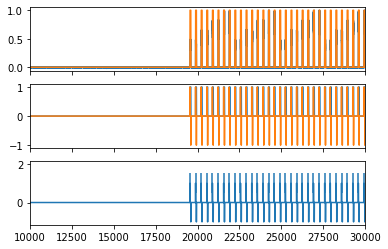

In [12]:
fig,ax = plt.subplots(3,1, sharex = True)
ax[0].plot(triggers[:40000]/triggers[:40000].max())
ax[0].plot(tri[:40000])
ax[1].plot(tri[:40000])
#plt.plot(trig[20000:40000])
ax[1].plot(up[:40000])
ax[2].plot(up[:40000])
ax[2].eventplot(trig[:40000])
ax[2].set_xlim(10000,30000)

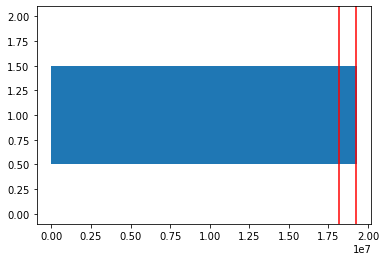

In [13]:
plt.eventplot(trig[:57001])
plt.axvline(trig[54001], color = 'r')
plt.axvline(trig[57001], color = 'r')

In [14]:
trigdf = pd.DataFrame(trig, columns=['Times'])

In [21]:
np.unique(np.diff(trig))
trig_clean = trig[np.where(np.diff(trig) < 348)[0]]
trig_clean

array([    19544,     19879,     20215, ..., 133106860, 133107195,
       133107530])

(array([3.80285e+05, 0.00000e+00, 1.00000e+00, 0.00000e+00, 5.40000e+01,
        6.00000e+00, 0.00000e+00, 1.50000e+01, 1.00000e+00, 1.00000e+00]),
 array([   206. ,  14274.3,  28342.6,  42410.9,  56479.2,  70547.5,
         84615.8,  98684.1, 112752.4, 126820.7, 140889. ]),
 <BarContainer object of 10 artists>)

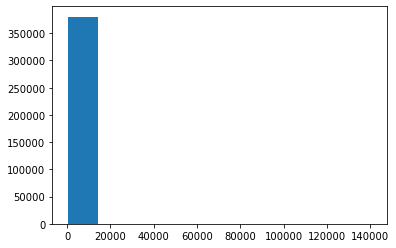

In [25]:
plt.hist(np.diff(trig_clean))

In [26]:
frmrt = 1/(np.mean(np.diff(trig_clean))/20000)
print(f'framerate from trigger: {frmrt} Hz')

framerate from trigger: 57.15962972044674 Hz


In [220]:
# fig, ax = plt.subplots(3,1,sharex = True)

# ax[0].plot(triggers[:22000])
# ax[1].plot(tri[:22000])
# ax[2].plot(up[:22000])
# ax[2].eventplot(trig, color = 'r')


# load spike data

In [27]:
fp = f'/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/Simone/MR-0605/sorting/MR-0605_results_curated.hdf5'
dat = h5py.File(fp, 'r')


In [28]:
keys = list(dat['spiketimes'].keys())
spiketimes = dat['spiketimes'] # spike times in frames
sampling_frequency = 20000.0


# load events

In [29]:
fp = f'/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/Simone/MR-0605/sync/event_list_MR-0605_.csv'
events = pd.read_csv(fp)
events

# start_event  and end_event contain the start  and end TIMES for each trial, in sampling frequency (?)

,n_frames,start_event,end_event,start_next_event,event_duration,inter_event_duration,start_event_sec,end_event_sec,start_next_event_sec,event_duration_sec,inter_event_duration_sec,protocol_name,nd,intensity,extra_description,repetition_name,repeated_frames,#repeated_frames
0,54001,19592,18126255,18277300,18106663,151045,0.97960,906.31275,913.86500,905.33315,7.55225,checkerboard,nd4,255.0,30Hz,rep_000,[ 19592 20263 20933 ... 18124243 18124...,27001
1,3000,18277300,19283207,19343226,1005907,60019,913.86500,964.16035,967.16130,50.29535,3.00095,gratings,nd5,255.0,flickering,rep_000,[],0
2,3000,19343226,20349133,20409153,1005907,60020,967.16130,1017.45665,1020.45765,50.29535,3.00100,gratings,nd5,255.0,flickering,rep_001,[],0
3,3007,20409153,21417407,21477426,1008254,60019,1020.45765,1070.87035,1073.87130,50.41270,3.00095,gratings,nd5,255.0,flickering,rep_002,[20898694 20899030 20899365 20899700 20900035 ...,7
4,3001,21477426,22483668,22543688,1006242,60020,1073.87130,1124.18340,1127.18440,50.31210,3.00100,gratings,nd5,255.0,flickering,rep_003,[22020616],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,3600,127809741,129016829,129117084,1207088,100255,6390.48705,6450.84145,6455.85420,60.35440,5.01275,natural_images,nd4,255.0,30Hz,rep_006,[127809741 127810411 127811082 ... 129014817 1...,1800
68,3600,129117084,130324172,130424428,1207088,100256,6455.85420,6516.20860,6521.22140,60.35440,5.01280,natural_images,nd4,255.0,30Hz,rep_007,[129117084 129117755 129118426 ... 130322161 1...,1800
69,3600,130424428,131631516,131731772,1207088,100256,6521.22140,6581.57580,6586.58860,60.35440,5.01280,natural_images,nd4,255.0,30Hz,rep_008,[130424428 130425099 130425769 ... 131629504 1...,1800
70,3600,131731772,132938860,132938860,1207088,0,6586.58860,6646.94300,6646.94300,60.35440,0.00000,natural_images,nd4,255.0,30Hz,rep_009,[131731772 131732442 131733113 ... 132936848 1...,1800


In [30]:
# group by stimulus
g = events.groupby('protocol_name')
protocols = list(g.groups.keys())
print(f'protocols : {protocols}')



# group by intensity
events_gratings = g.get_group("gratings")
gi = events_gratings.groupby('nd')
intensities = list(gi.groups.keys())
print(f'intensitites : {intensities}')

protocols : ['checkerboard', 'gratings', 'natural_images']
intensitites : ['nd3', 'nd4', 'nd5']


In [31]:
trigdf

,Times
0,19544
1,19879
2,20215
3,20550
4,20885
...,...
380438,133106524
380439,133106860
380440,133107195
380441,133107530


# extract trigger frames for each stim

In [32]:
events['n_frames'].iloc[0]

54001

In [33]:
start_frame = 0
trs_all_events = []
for row in range(len(events)):
    end_frame = start_frame + events['n_frames'].iloc[row]
    print(row,start_frame, end_frame)

    trs = np.array(trig[start_frame:end_frame])
    start_frame = end_frame

    trs_all_events.append(trs)

0 0 54001
1 54001 57001
2 57001 60001
3 60001 63008
4 63008 66009
5 66009 69009
6 69009 72009
7 72009 75009
8 75009 78009
9 78009 81009
10 81009 84009
11 84009 87009
12 87009 90009
13 90009 93018
14 93018 96019
15 96019 99019
16 99019 102019
17 102019 105019
18 105019 108019
19 108019 111019
20 111019 114019
21 114019 117019
22 117019 120019
23 120019 123019
24 123019 126027
25 126027 129027
26 129027 132027
27 132027 135027
28 135027 138027
29 138027 141027
30 141027 144027
31 144027 147027
32 147027 150027
33 150027 153027
34 153027 156028
35 156028 159028
36 159028 162028
37 162028 165028
38 165028 168028
39 168028 171028
40 171028 174028
41 174028 177028
42 177028 180028
43 180028 183028
44 183028 186035
45 186035 189035
46 189035 192035
47 192035 195035
48 195035 198035
49 198035 201035
50 201035 204035
51 204035 207035
52 207035 210035
53 210035 213035
54 213035 216044
55 216044 219044
56 219044 222044
57 222044 225044
58 225044 228044
59 228044 231044
60 231044 234044
61 234044 

# align spikes and stimulus in each trial, use time

In [34]:
keys_short = ['temp_3', 'temp_6', 'temp_10', 'temp_11']


In [35]:
# exract raster per trial and calculate PSTH

nb_trials = 10
trials =np.array([1,2,3,4,5,6,7,8,9])
nb_stimuli = 25

# in frames
dt = 0.02*sampling_frequency
stim_length = events_gratings['event_duration'].values[0]
time = np.arange(0,stim_length,dt)

# in seconds
dt_sec = 0.02
stim_length_sec = events_gratings['event_duration'].values[0]/sampling_frequency
time_sec = np.arange(0,stim_length_sec,dt_sec)

bin_edges = np.append(time_sec, 2 * time_sec[-1] - time_sec[-2])


checker_frames = events.loc[events['protocol_name'] == 'checkerboard' ]['n_frames'].values[0]
sigma = 3


data = {}
data['stimuli']={}
data['triggers']={}
data['triggers_sorted']={}

for key in tqdm(keys):
   
    data[key] = {}
    spktms = spiketimes[key][()].flatten()
    df = pd.DataFrame(spktms,  columns = ['Times'])

    for i in intensities:

        data['stimuli'][i]={}
        data['triggers'][i]={}
        data['triggers_sorted'][i]={}

        data[key][i] = {}
        evts_i= gi.get_group(i)
        ggr = evts_i.groupby("extra_description")
        grating_types = list(ggr.groups.keys())

        for grat in grating_types:
            
            data['stimuli'][i][grat] = {}
            data['triggers'][i][grat] = {}
            data['triggers_sorted'][i][grat] = {}
            data[key][i][grat] = {}

            evts = ggr.get_group(grat)
            start = evts['start_event'].values
            end = evts['end_event'].values

            idxs = np.array(evts.index)

            nb_frames= evts['n_frames']


            rasters = []
            trigs = []
            trigs_sorted = []
            stims = []

            

            for nb in range(nb_trials):
                if nb ==0:
                    continue

                sti = stim_full[start[nb]:end[nb]]

                tr = trigdf.query(f"Times>={start[nb]} & Times<={end[nb]}") - start[nb]
                tr = np.asarray(tr["Times"])/sampling_frequency

                times = df.query(f"Times>={start[nb]} & Times<={end[nb]}") - start[nb]

                # tr = trs_all_events[idxs[nb]]-trs_all_events[idxs[nb]][0]
                # tr = tr/sampling_frequency
                tr_sorted = []
                for nbs in range(nb_stimuli):
                    try:
                        tr_sorted.append(tr[nbs*120:nbs*120 + 120])
                    except: 
                        tr_sorted.append(tr[nbs*120:])

                rasters.append(np.asarray(times["Times"])/sampling_frequency)
                stims.append(sti)
                trigs.append(tr)
                trigs_sorted.append(tr_sorted)


            spike_times_all_trials = np.concatenate(rasters, axis= 0)
            count, bins = np.histogram(spike_times_all_trials, bins=bin_edges, density=False) 
            count_smooth = gaussian_filter(count,sigma)/10

            data[key][i][grat]['rasters'] = rasters

            data[key][i][grat]['count'] = count

            data['stimuli'][i][grat]['full_stim'] = stims
            data['triggers'][i][grat] = trigs
            data['triggers_sorted'][i][grat] = trigs_sorted

In [36]:
nb_trials = 9

# check stimulus trace

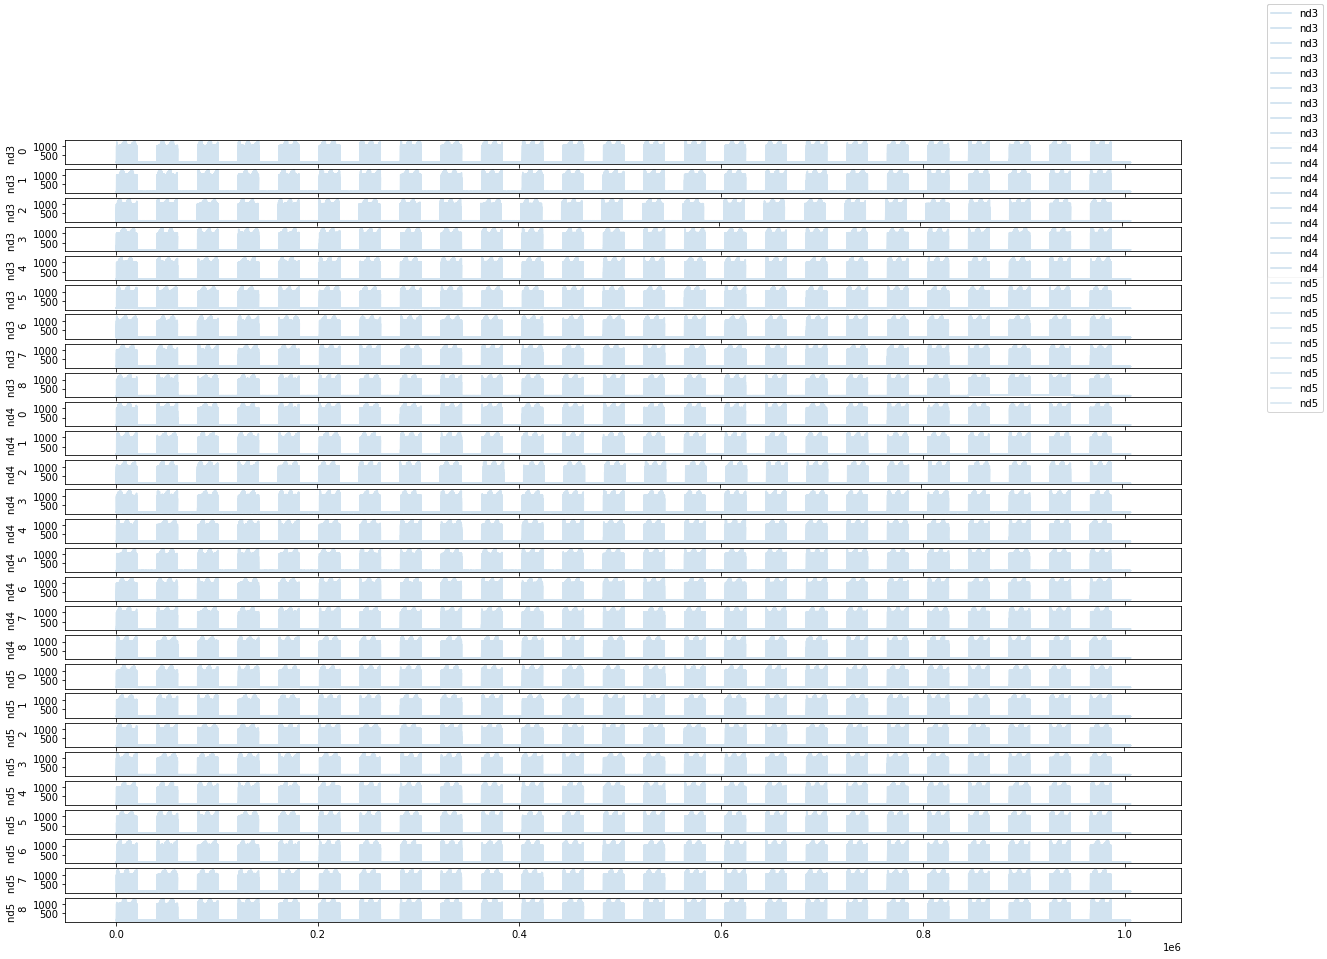

In [37]:
fpplots = '/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/Simone/MR-0605/results/plots_overview/flickering_grating'

colors_flicker = ['teal','turquoise','cyan']

grat = grating_types[1]
fig = plt.figure(figsize = (20,16))
gs = fig.add_gridspec(30,1)



row = -1
for ix,i in enumerate(intensities):

    for nx in range(nb_trials):
        
        row = row + 1
        ax00 = fig.add_subplot(gs[row,0])
        ax00.plot(data['stimuli'][i][grat]['full_stim'][nx],label = f'{i}', alpha = 0.2)
        ax00.set_ylabel(f'{i} \n {nx}')
        



    fig.legend()




# PLOT - overview one cell all stimuli

In [38]:
%matplotlib inline

In [39]:
figure_mode = 'show'

## flicker

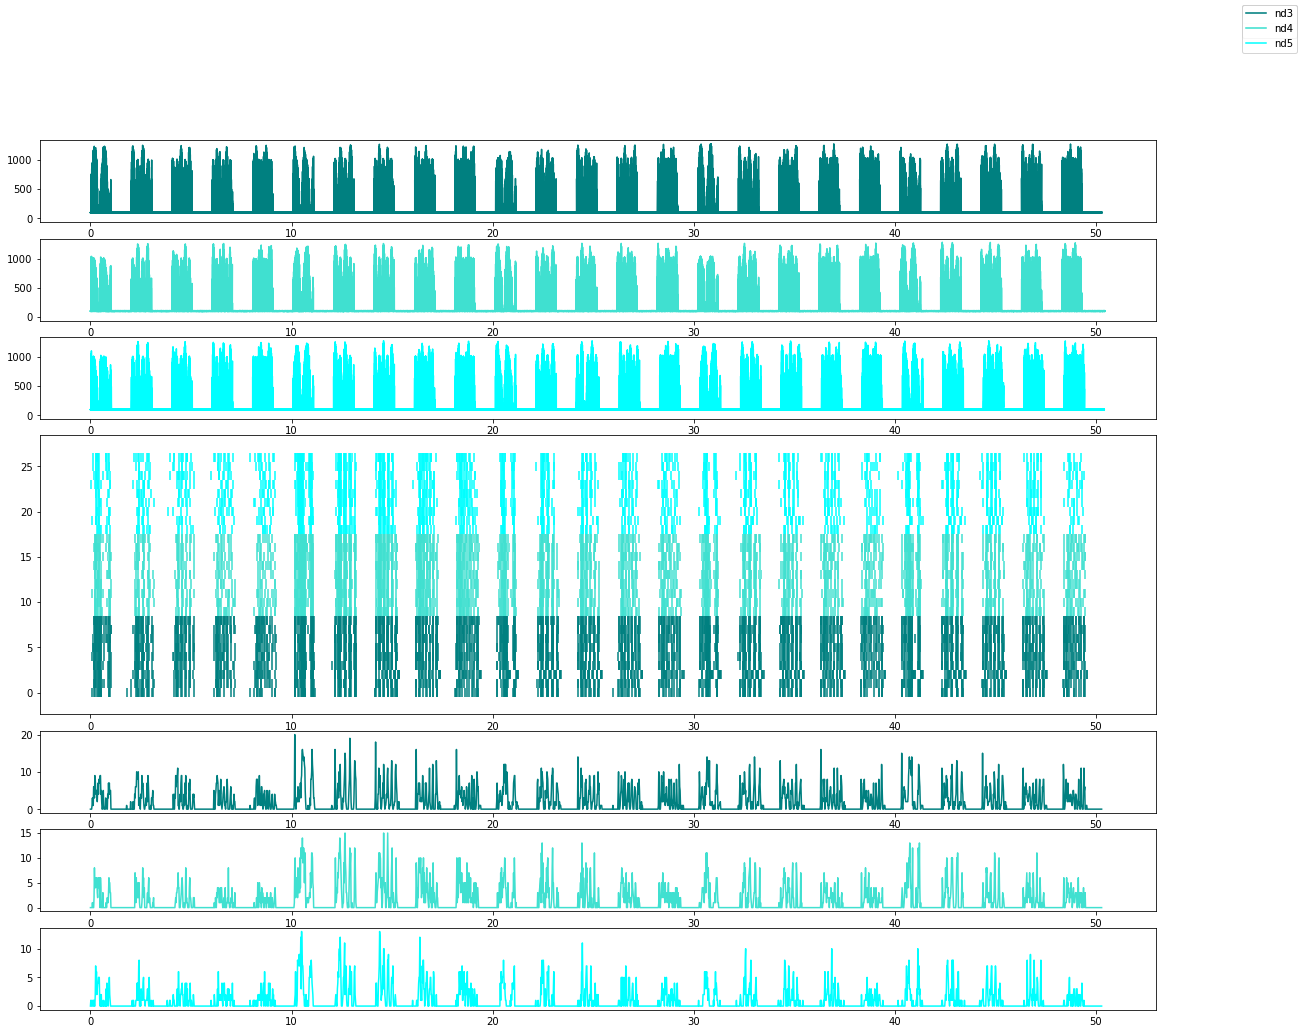

In [40]:
fpplots = '/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/Simone/MR-0605/results/plots_overview/flickering_grating'

colors_flicker = ['teal','turquoise','cyan']

grat = grating_types[0]

if figure_mode == 'show':
    fig = plt.figure(figsize = (20,16))
    gs = fig.add_gridspec(9,1)



    ax00 = fig.add_subplot(gs[0,0])
    ax01 = fig.add_subplot(gs[1,0], sharex = ax00)
    ax02 = fig.add_subplot(gs[2,0], sharex = ax00)

    ax1 = fig.add_subplot(gs[3:6,0], sharex = ax00)

    ax20 = fig.add_subplot(gs[6,0], sharex = ax00)
    ax21= fig.add_subplot(gs[7,0], sharex = ax00)
    ax22 = fig.add_subplot(gs[8,0], sharex = ax00)

    for ix,i in enumerate(intensities):
        #plot stim
            #print(len(data['stimuli'][i][grat][x]))


        #ax[1].eventplot(data['triggers'][i][grat])

        rasters = data[key][i][grat]['rasters']
        ax1.eventplot(rasters,lineoffsets = np.arange(nb_trials)+(ix*nb_trials), color = colors_flicker[ix])

        count = data[key][i][grat]['count']
        if ix ==0:
            # for nx in range(nb_trials):
            #     ax00.plot(data['stimuli'][i][grat]['full_stim'][nx]/data['stimuli'][i][grat]['full_stim'][nx].max(),label = f'{i}')
            ax00.plot(np.arange(0,len(data['stimuli'][i][grat]['full_stim'][1]))*1/sampling_frequency,data['stimuli'][i][grat]['full_stim'][1],label = f'{i}', color = colors_flicker[ix])
            
            #ax00.plot(np.arange(0,stim_length/sampling_frequency,1/sampling_frequency),data['stimuli'][i][grat]['full_stim'][1],label = f'{i}', color = colors_flicker[ix])
            #ax00.plot(np.arange(0,stim_length/sampling_frequency,1/sampling_frequency),data['stimuli'][i][grat]['full_stim'][0]/data['stimuli'][i][grat]['full_stim'][0].max(),label = f'{i}', color = colors_flicker[ix])
            ax20.plot(time/sampling_frequency,count, color = colors_flicker[ix])
            ax00.eventplot(data['triggers'][i][grat][0])


        if ix ==1:
            # for nx in range(nb_trials):
            #     ax01.plot(data['stimuli'][i][grat]['full_stim'][nx]/data['stimuli'][i][grat]['full_stim'][nx].max(),label = f'{i}')
            ax01.plot(np.arange(0,len(data['stimuli'][i][grat]['full_stim'][1]))*1/sampling_frequency,data['stimuli'][i][grat]['full_stim'][1],label = f'{i}', color = colors_flicker[ix])
            ax21.plot(time/sampling_frequency,count, color = colors_flicker[ix])
            ax01.eventplot(data['triggers'][i][grat][0])


        if ix ==2:
            # for nx in range(nb_trials):
            #     ax02.plot(data['stimuli'][i][grat]['full_stim'][nx]/data['stimuli'][i][grat]['full_stim'][nx].max(),label = f'{i}')
            ax02.plot(np.arange(0,len(data['stimuli'][i][grat]['full_stim'][1]))*1/sampling_frequency,data['stimuli'][i][grat]['full_stim'][1],label = f'{i}', color = colors_flicker[ix])
            ax22.plot(time/sampling_frequency,count, color = colors_flicker[ix])
            ax02.eventplot(data['triggers'][i][grat][0])



        fig.legend()



if figure_mode == 'save':
    for key in keys:
        fig = plt.figure(figsize = (20,16))
        gs = fig.add_gridspec(9,1)



        ax00 = fig.add_subplot(gs[0,0])
        ax01 = fig.add_subplot(gs[1,0], sharex = ax00)
        ax02 = fig.add_subplot(gs[2,0], sharex = ax00)

        ax1 = fig.add_subplot(gs[3:6,0], sharex = ax00)

        ax20 = fig.add_subplot(gs[6,0], sharex = ax00)
        ax21= fig.add_subplot(gs[7,0], sharex = ax00)
        ax22 = fig.add_subplot(gs[8,0], sharex = ax00)

        for ix,i in enumerate(intensities):
            #plot stim
                #print(len(data['stimuli'][i][grat][x]))


            #ax[1].eventplot(data['triggers'][i][grat])

            rasters = data[key][i][grat]['rasters']
            ax1.eventplot(rasters,lineoffsets = np.arange(nb_trials)+(ix*nb_trials), color = colors_flicker[ix])

            count = data[key][i][grat]['count']
            if ix ==0:
                # for nx in range(nb_trials):
                #     ax00.plot(data['stimuli'][i][grat]['full_stim'][nx]/data['stimuli'][i][grat]['full_stim'][nx].max(),label = f'{i}')
                ax00.plot(np.arange(0,len(data['stimuli'][i][grat]['full_stim'][1]))*1/sampling_frequency,data['stimuli'][i][grat]['full_stim'][1],label = f'{i}', color = colors_flicker[ix])
                
                #ax00.plot(np.arange(0,stim_length/sampling_frequency,1/sampling_frequency),data['stimuli'][i][grat]['full_stim'][1],label = f'{i}', color = colors_flicker[ix])
                #ax00.plot(np.arange(0,stim_length/sampling_frequency,1/sampling_frequency),data['stimuli'][i][grat]['full_stim'][0]/data['stimuli'][i][grat]['full_stim'][0].max(),label = f'{i}', color = colors_flicker[ix])
                ax20.plot(time/sampling_frequency,count, color = colors_flicker[ix])
                ax00.eventplot(data['triggers'][i][grat][0])


            if ix ==1:
                # for nx in range(nb_trials):
                #     ax01.plot(data['stimuli'][i][grat]['full_stim'][nx]/data['stimuli'][i][grat]['full_stim'][nx].max(),label = f'{i}')
                ax01.plot(np.arange(0,len(data['stimuli'][i][grat]['full_stim'][1]))*1/sampling_frequency,data['stimuli'][i][grat]['full_stim'][1],label = f'{i}', color = colors_flicker[ix])
                ax21.plot(time/sampling_frequency,count, color = colors_flicker[ix])
                ax01.eventplot(data['triggers'][i][grat][0])


            if ix ==2:
                # for nx in range(nb_trials):
                #     ax02.plot(data['stimuli'][i][grat]['full_stim'][nx]/data['stimuli'][i][grat]['full_stim'][nx].max(),label = f'{i}')
                ax02.plot(np.arange(0,len(data['stimuli'][i][grat]['full_stim'][1]))*1/sampling_frequency,data['stimuli'][i][grat]['full_stim'][1],label = f'{i}', color = colors_flicker[ix])
                ax22.plot(time/sampling_frequency,count, color = colors_flicker[ix])
                ax02.eventplot(data['triggers'][i][grat][0])



            fig.legend()
            fig.savefig(f'{fpplots}/{key}.png')
            plt.close()


In [41]:
ax00.eventplot(data['triggers'][i][grat][4])


In [42]:
count

array([0, 1, 1, ..., 0, 0, 0])

## moving

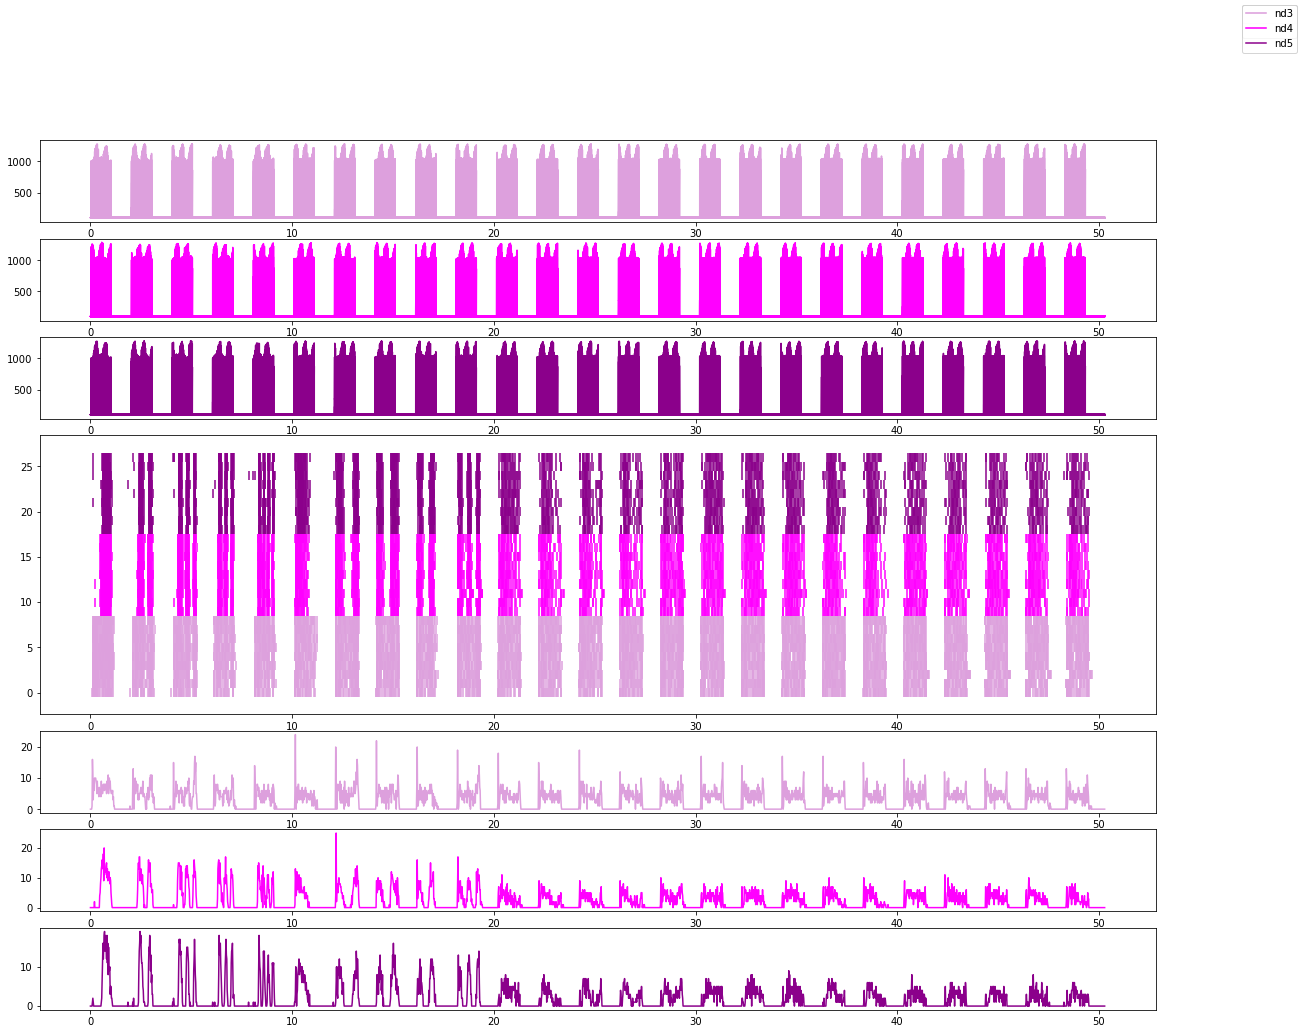

In [43]:
fpplots = '/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/Simone/MR-0605/results/plots_overview/moving_grating'
colors_moving = ['plum','magenta','darkmagenta']

grat = grating_types[1]

if figure_mode == 'show':
    fig = plt.figure(figsize = (20,16))
    gs = fig.add_gridspec(9,1)


    ax00 = fig.add_subplot(gs[0,0])
    ax01 = fig.add_subplot(gs[1,0], sharex = ax00)
    ax02 = fig.add_subplot(gs[2,0], sharex = ax00)

    ax1 = fig.add_subplot(gs[3:6,0], sharex = ax00)

    ax20 = fig.add_subplot(gs[6,0], sharex = ax00)
    ax21= fig.add_subplot(gs[7,0], sharex = ax00)
    ax22 = fig.add_subplot(gs[8,0], sharex = ax00)

    for ix,i in enumerate(intensities):
        #plot stim
            #print(len(data['stimuli'][i][grat][x]))

        #ax[1].eventplot(data['triggers'][i][grat])

        rasters = data[key][i][grat]['rasters']
        ax1.eventplot(rasters,lineoffsets = np.arange(nb_trials)+(ix*nb_trials), color = colors_moving[ix])

        count = data[key][i][grat]['count']
        if ix ==0:
            ax00.plot(np.arange(0,len(data['stimuli'][i][grat]['full_stim'][1]))*1/sampling_frequency,data['stimuli'][i][grat]['full_stim'][1],label = f'{i}', color = colors_moving[ix])
            ax20.plot(time/sampling_frequency,count, color = colors_moving[ix])

        if ix ==1:
            ax01.plot(np.arange(0,len(data['stimuli'][i][grat]['full_stim'][1]))*1/sampling_frequency,data['stimuli'][i][grat]['full_stim'][1],label = f'{i}', color = colors_moving[ix])
            ax21.plot(time/sampling_frequency,count, color = colors_moving[ix])

        if ix ==2:
            ax02.plot(np.arange(0,len(data['stimuli'][i][grat]['full_stim'][1]))*1/sampling_frequency,data['stimuli'][i][grat]['full_stim'][1],label = f'{i}', color = colors_moving[ix])
            ax22.plot(time/sampling_frequency,count, color = colors_moving[ix])

        fig.legend()


if figure_mode == 'save':
    
    for key in keys:
        fig = plt.figure(figsize = (20,16))
        gs = fig.add_gridspec(9,1)

        ax00 = fig.add_subplot(gs[0,0])
        ax01 = fig.add_subplot(gs[1,0], sharex = ax00)
        ax02 = fig.add_subplot(gs[2,0], sharex = ax00)

        ax1 = fig.add_subplot(gs[3:6,0], sharex = ax00)

        ax20 = fig.add_subplot(gs[6,0], sharex = ax00)
        ax21= fig.add_subplot(gs[7,0], sharex = ax00)
        ax22 = fig.add_subplot(gs[8,0], sharex = ax00)

        for ix,i in enumerate(intensities):
            #plot stim
                #print(len(data['stimuli'][i][grat][x]))

            #ax[1].eventplot(data['triggers'][i][grat])

            rasters = data[key][i][grat]['rasters']
            ax1.eventplot(rasters,lineoffsets = np.arange(nb_trials)+(ix*nb_trials), color = colors_moving[ix])

            count = data[key][i][grat]['count']
            if ix ==0:
                ax00.plot(data['stimuli'][i][grat][0],label = f'{i}', color = colors_moving[ix])
                ax20.plot(time,count, color = colors_moving[ix])

            if ix ==1:
                ax01.plot(data['stimuli'][i][grat][0],label = f'{i}', color = colors_moving[ix])
                ax21.plot(time,count, color = colors_moving[ix])

            if ix ==2:
                ax02.plot(data['stimuli'][i][grat][0],label = f'{i}', color = colors_moving[ix])
                ax22.plot(time,count, color = colors_moving[ix])

        fig.legend()
        fig.savefig(f'{fpplots}/{key}.png')
        plt.close()

# extract spikes per stimulus

In [48]:
# extract spiketimes per stimulus

frame_duration = 1/59.9 #s
stim_duration = 60*frame_duration
#stim_duration = 1.0


stim_length_ot = 2*stim_duration
time_ot = np.arange(0,stim_length_ot,dt_sec)
bin_edges_ot = np.append(time_ot, 2 * time_ot[-1] - time_ot[-2])


for key in tqdm(keys):

    for i in intensities:

        for grat in grating_types:

            rasters_sorted_stim = []
            rasters_sorted_stim_aligned = []
            #rasters_sorted_base = []

            counts_sorted_stim = []
            maxis_sorted_stim = []
            means_sorted_stim = []
            #counts_sorted_base = []

           
            #stims_sorted_base = []


            counts_sorted_stim_aligned = []
            maxis_sorted_stim_aligned= []
            means_sorted_stim_aligned = []

            #counts_sorted_base = []
            #stims_sorted_base = []
            
            rasters = data[key][i][grat]['rasters']
            sti = data['stimuli'][i][grat]['full_stim']

            if key == keys[0]:

                stims_sorted_stim_aligned= []
                start_sorted_stim_aligned = []

                stims_sorted_stim = []
                starts_sorted_stim = []

                

                for nbs in range(nb_stimuli):


                    start_stim  = 2*stim_duration*nbs
                    end_stim = start_stim + 1*stim_duration
                    start_base = end_stim
                    end_base = start_base + 1*stim_duration

                    start_stim_idx  = int(2*stim_duration*nbs*sampling_frequency)
                    end_stim_idx = start_stim_idx + 1*stim_duration*sampling_frequency
                    start_base_idx = end_stim_idx
                    end_base_idx = int(start_base_idx + 1*stim_duration*sampling_frequency)


                    stims_per_stim = []
                    stims_per_stim_aligned = []
                    start_stim_exs = []
                    
                    for nb in range(nb_trials):

                        sti_stim = sti[nb][int(start_stim_idx):int(end_base_idx)]
                        stims_per_stim.append(sti_stim)

                        # extract from photodiode signal
                        dets = np.diff(sti_stim)>250
                        xf = np.where(dets == True)
                        
                        if nbs == 0:
                            ref = xf[0][0]
                            start_stim_ex_idx = 0

                        else:
                            start_stim_ex_idx  = xf[0][0]-ref

                        end_base_ex_idx  = int(start_stim_ex_idx+40000)
                        
                        start_stim_ex  = start_stim_ex_idx/sampling_frequency
                        end_base_ex  = end_base_ex_idx/sampling_frequency
                        # except:
                        #     print(nbs,nb)
                        #     start_stim_ex  = 0
                        #     end_base_ex  = 40000

                        start_stim_exs.append(start_stim_ex)
                        
                        sti_stim_aligned = sti_stim[start_stim_ex_idx:end_base_ex_idx]
                        stims_per_stim_aligned.append(sti_stim_aligned)

                    start_sorted_stim_aligned.append(start_stim_exs)
                    stims_sorted_stim.append(stims_per_stim)
                    starts_sorted_stim.append(start_stim)
                    stims_sorted_stim_aligned.append(stims_per_stim_aligned)





            for nbs in range(nb_stimuli):

                rasters_pers_stim = []
                rasters_pers_stim_aligned = []
                #rasters_pers_base = []
                

                #stims_per_base = []
                start_stim = starts_sorted_stim[nbs]
                
                for nb in range(nb_trials):

                    # start_stim_trig  = data['triggers_sorted'][i][grat][nb][nbs][0]
                    # end_base_trig = data['triggers_sorted'][i][grat][nb][nbs][-1]

                    
                    times = pd.DataFrame(rasters[nb], columns = ['Times'])
                    #print(len(times), times["Times"][0],times["Times"][len(times["Times"])-1])
                    times_stim = times.query(f"Times>= {start_stim} & Times<= {end_base}") - start_stim


                    start_aligned = float(start_stim + start_sorted_stim_aligned[nbs][nb])
                    end_aligned = start_aligned + 2.0
                    #print(start_stim, start_aligned,end_aligned)

                    times_stim_aligned = times.query(f"Times>= {start_aligned} & Times<= {end_aligned}") - start_aligned
                    #times_stim_aligned = times_stim.query(f"Times>= {start_stim_aligned[nb]} & Times<= {start_stim_aligned[nb]+2.0}") - start_stim_aligned[nb]
                    #times_base = times.query(f"Times>= {start_base} & Times<= {end_base}") - start_base

                    #sti_base = sti[nb][int(start_stim):int(end_base)]

                    rasters_pers_stim.append(np.asarray(times_stim["Times"]))
                    rasters_pers_stim_aligned.append(np.asarray(times_stim_aligned["Times"]))
                    # if nb ==0 :
                    #     print(np.asarray(times_stim["Times"]))

                    #rasters_pers_base.append(np.asarray(times_base["Times"]))

                    #stims_per_base.append(sti_base)


                spike_times_all_trials_stim = np.concatenate(rasters_pers_stim, axis= 0)
                count_stim, bins = np.histogram(spike_times_all_trials_stim, bins=bin_edges_ot, density=False) 
                count_smooth_stim = gaussian_filter(count_stim,sigma)/10
                maxi = np.max(count_smooth_stim)
                mean = np.mean(count_smooth_stim)

                counts_sorted_stim.append(count_smooth_stim)
                maxis_sorted_stim.append(maxi)
                means_sorted_stim.append(mean)


                spike_times_all_trials_stim_aligned = np.concatenate(rasters_pers_stim_aligned, axis= 0)
                count_stim_aligned, bins = np.histogram(spike_times_all_trials_stim_aligned, bins=bin_edges_ot, density=False) 
                count_smooth_stim_aligned = gaussian_filter(count_stim_aligned,sigma)/nb_trials
                maxi_aligned= np.max(count_smooth_stim_aligned)
                mean_aligned = np.mean(count_smooth_stim_aligned)

                counts_sorted_stim_aligned.append(count_smooth_stim_aligned)
                maxis_sorted_stim.append(maxi_aligned)
                means_sorted_stim.append(mean_aligned)

                #spike_times_all_trials_base = np.concatenate(rasters_pers_base, axis= 0)
                #count_base, bins = np.histogram(spike_times_all_trials_base, bins=bin_edges_ot, density=False) 
                #count_smooth_base = gaussian_filter(count_base,sigma)/10

                #counts_sorted_base.append(count_smooth_base)


                rasters_sorted_stim.append(rasters_pers_stim)
                rasters_sorted_stim_aligned.append(rasters_pers_stim_aligned)
                #rasters_sorted_base.append(rasters_pers_base)

                # stims_per_stim = np.mean(stims_per_stim, axis = 0)
                # stims_per_base = np.mean(stims_per_base,axis = 0)
                if key == 'temp_3':
                    stims_sorted_stim.append(stims_per_stim)
                    starts_sorted_stim.append(start_sorted_stim_aligned)
                    stims_sorted_stim_aligned.append(stims_per_stim_aligned)
                #stims_sorted_base.append(stims_per_base)


            data[key][i][grat]['rasters_sorted_stim'] = rasters_sorted_stim
            data[key][i][grat]['rasters_sorted_stim_aligned'] = rasters_sorted_stim_aligned
            #data[key][i][grat]['rasters_sorted_base'] = rasters_sorted_base

            data[key][i][grat]['counts_sorted_stim'] = counts_sorted_stim
            data[key][i][grat]['counts_sorted_stim_alinged'] = counts_sorted_stim_aligned
            #data[key][i][grat]['counts_sorted_base'] = counts_sorted_base

            data[key][i][grat]['max_sorted_stim'] = maxis_sorted_stim
            data[key][i][grat]['mean_sorted_stim'] = means_sorted_stim
            data[key][i][grat]['max_sorted_stim_aligned'] = maxis_sorted_stim_aligned
            data[key][i][grat]['mean_sorted_stim_alinged'] = means_sorted_stim_aligned
            #data[key][i][grat]['max_sorted_base'] = np.max(counts_sorted_base)

            if key == keys[0]:
                data['stimuli'][i][grat]['stimuli_sorted_stim'] = stims_sorted_stim
                data['stimuli'][i][grat]['starts_sorted_stim'] = starts_sorted_stim
                data['stimuli'][i][grat]['stimuli_sorted_stim_aligned'] = stims_sorted_stim_aligned
            #data[key][i][grat]['stimuli_sorted_base'] = stims_sorted_base




100%|██████████| 240/240 [12:52<00:00,  3.22s/it]


In [54]:
data['temp_3'][i][grat].keys()

dict_keys(['rasters', 'count', 'rasters_sorted_stim', 'rasters_sorted_stim_aligned', 'counts_sorted_stim', 'counts_sorted_stim_alinged', 'max_sorted_stim', 'mean_sorted_stim', 'max_sorted_stim_aligned', 'mean_sorted_stim_alinged'])

In [53]:
key

'temp_98'

In [52]:
# # #save data
fpdata = '/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/Simone/MR-0605/results/data.pkl'
with open(fpdata, "wb") as handle:   #Pickling
    pickle.dump(data, handle,protocol=4 )
    

In [46]:
fps = '/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/stimuli/flickering_gratings/event_list_flickering_gratings.csv'

# PLOT  - responses to each stimulus

In [244]:
#key = keys[2]
key = 'temp_3'
print(key)
i = intensities[2]
grat = grating_types[0]

fxs = np.array([1,2,4,6,10])
fts = np.array([2,4,5,6,8])

vss = []
for i in range(len(fxs)):
    vs = fts/fxs[i]
    vss.append(vs)

temp_3


##  flicker compare intensities

/tmp/ipykernel_353855/4074565679.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  mean_ratio = mean_stim/mean_base
/tmp/ipykernel_353855/4074565679.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  mean_ratio = mean_stim/mean_base
/tmp/ipykernel_353855/4074565679.py:37: RuntimeWarning: invalid value encountered in double_scalars
  mean_ratio = mean_stim/mean_base
/tmp/ipykernel_353855/4074565679.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  mean_ratio = mean_stim/mean_base
/tmp/ipykernel_353855/4074565679.py:37: RuntimeWarning: invalid value encountered in double_scalars
  mean_ratio = mean_stim/mean_base
/tmp/ipykernel_353855/4074565679.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  mean_ratio = mean_stim/mean_base
/tmp/ipykernel_353855/4074565679.py:37: RuntimeWarning: invalid value encountered in double_scalars
  mean_ratio = mean_stim/mean_base
/tmp/ipykernel_353855/4074565679.py:37: RuntimeWarn

Text(0.5, 0.98, 'Firing Rate Responses to flickering gratings')

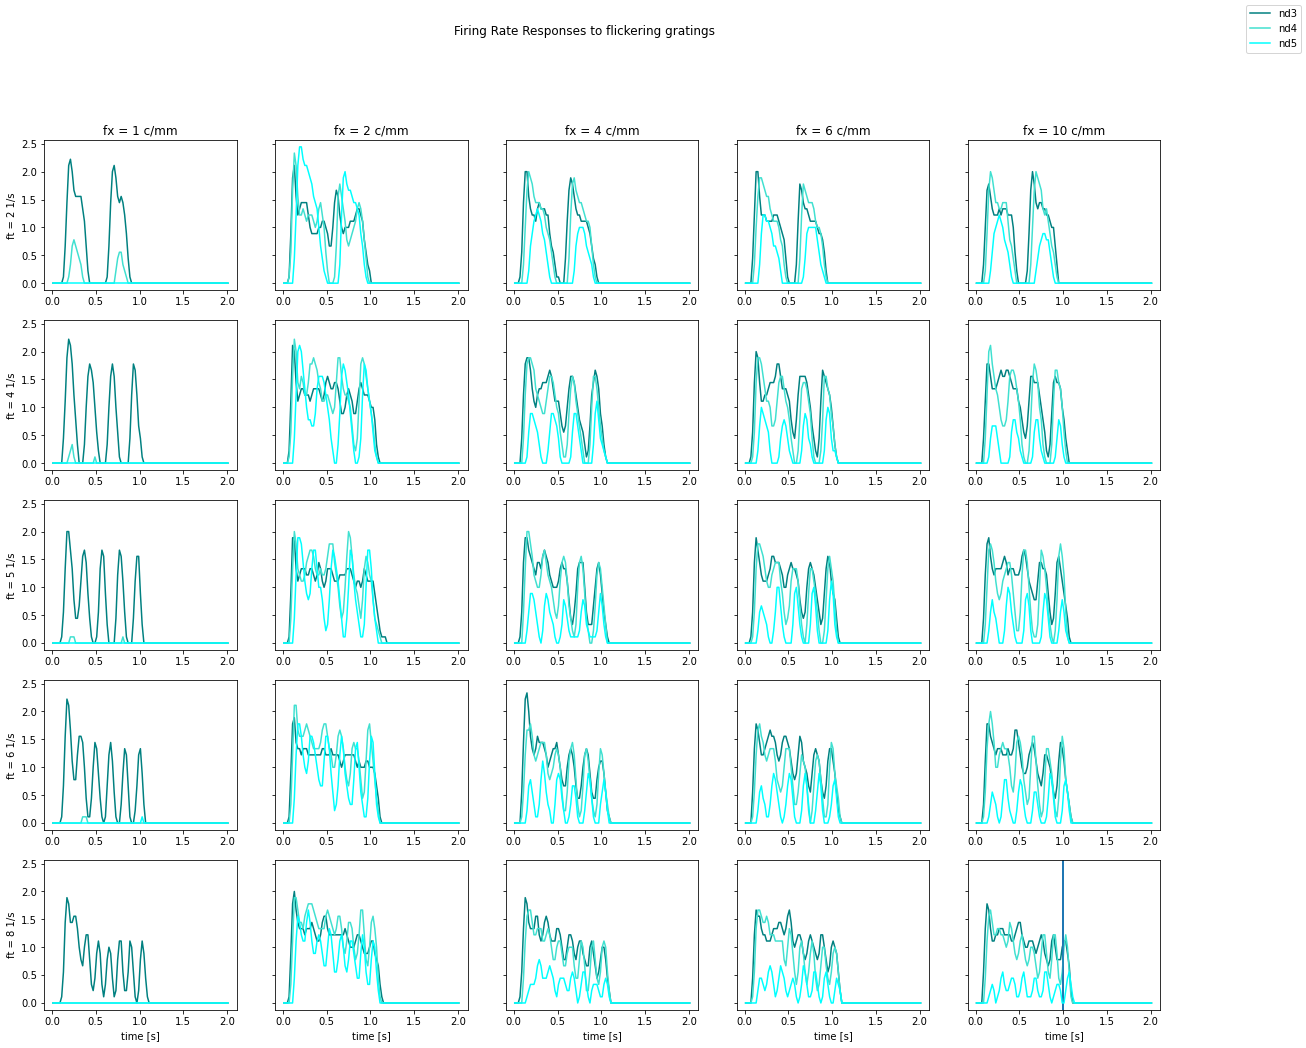

In [245]:
# resp_type = 'rasters_sorted_stim'
grat = grating_types[0]

resp_type = 'counts_sorted_stim_alinged'
#resp_type = 'counts_sorted_stim'

fig,ax = plt.subplots(5,5, sharey = True,figsize = (20,16))
heatdf_flicker = pd.DataFrame(columns = ['fx', 'ft','v' 'max','mean','intensity'])

for nbs in range(nb_stimuli):

    for ix,i in enumerate(intensities):

        row ={}

        y = int(np.floor(nbs/5))
        row['fx'] = float(fxs[y])
        
        x = int(nbs%5)
        row['ft'] = float(fts[x])
        row['v'] = float(fts[x]/fxs[y])

        row['intensity'] = i

        resp = data[key][i][grat][resp_type][nbs]
        stim = data['stimuli'][i][grat]['stimuli_sorted_stim'][nbs]

        start = data['stimuli'][i][grat]['starts_sorted_stim'][nbs]
        #end = data['stimuli'][i][grat]['ends_sorted_stim'][nbs]
        stim_trig = data['stimuli'][i][grat]['stimuli_sorted_stim_aligned'][nbs]

        idx = int(len(resp)/2)
        plt.axvline(time_ot[idx])
        
        mean_stim = np.mean(resp[:idx])
        mean_base = np.mean(resp[idx:])
        mean_ratio = mean_stim/mean_base

        data[key][i][grat]['means_stim'] = mean_stim
        data[key][i][grat]['means_base'] = mean_base
        data[key][i][grat]['means_ratio'] = mean_ratio

        row['max'] = float(resp.max())
        row['mean_stim'] = float(mean_stim)
        row['mean_base'] = float(mean_base)
        row['mean_ratio'] = float(mean_ratio)

        heatdf_flicker = heatdf_flicker.append(row, ignore_index=True)
        #ax[x,y].eventplot(resp)
        if nbs == 0:
            ax[x,y].plot((time_ot+0.5*dt_sec) ,resp, color = colors_flicker[ix], label = f'{i}')
        else:
            ax[x,y].plot((time_ot+0.5*dt_sec) ,resp, color = colors_flicker[ix])

        # if ix ==0:
        #     # ax[x,y].plot(stim[0], color = colors_flicker[ix])
        #     # ax[x,y].axvline(start[0]*sampling_frequency, color = 'r')
        #     print(start[0])
        #     ax[x,y].plot(stim_trig[0], color = 'r')

ax[0,0].set_title('fx = 1 c/mm')
ax[0,1].set_title('fx = 2 c/mm')
ax[0,2].set_title('fx = 4 c/mm')
ax[0,3].set_title('fx = 6 c/mm')
ax[0,4].set_title('fx = 10 c/mm')


ax[0,0].set_ylabel('ft = 2 1/s')
ax[1,0].set_ylabel('ft = 4 1/s')
ax[2,0].set_ylabel('ft = 5 1/s')
ax[3,0].set_ylabel('ft = 6 1/s')
ax[4,0].set_ylabel('ft = 8 1/s')

ax[4,0].set_xlabel('time [s]')
ax[4,1].set_xlabel('time [s]')
ax[4,2].set_xlabel('time [s]')
ax[4,3].set_xlabel('time [s]')
ax[4,4].set_xlabel('time [s]')


fig.legend()
fig.suptitle(f'Firing Rate Responses to {grat} gratings')


## moving, compare intenities

/tmp/ipykernel_353855/196045085.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  mean_ratio = mean_stim/mean_base
/tmp/ipykernel_353855/196045085.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  mean_ratio = mean_stim/mean_base


Text(0.5, 0.98, 'Firing Rate Responses to moving gratings')

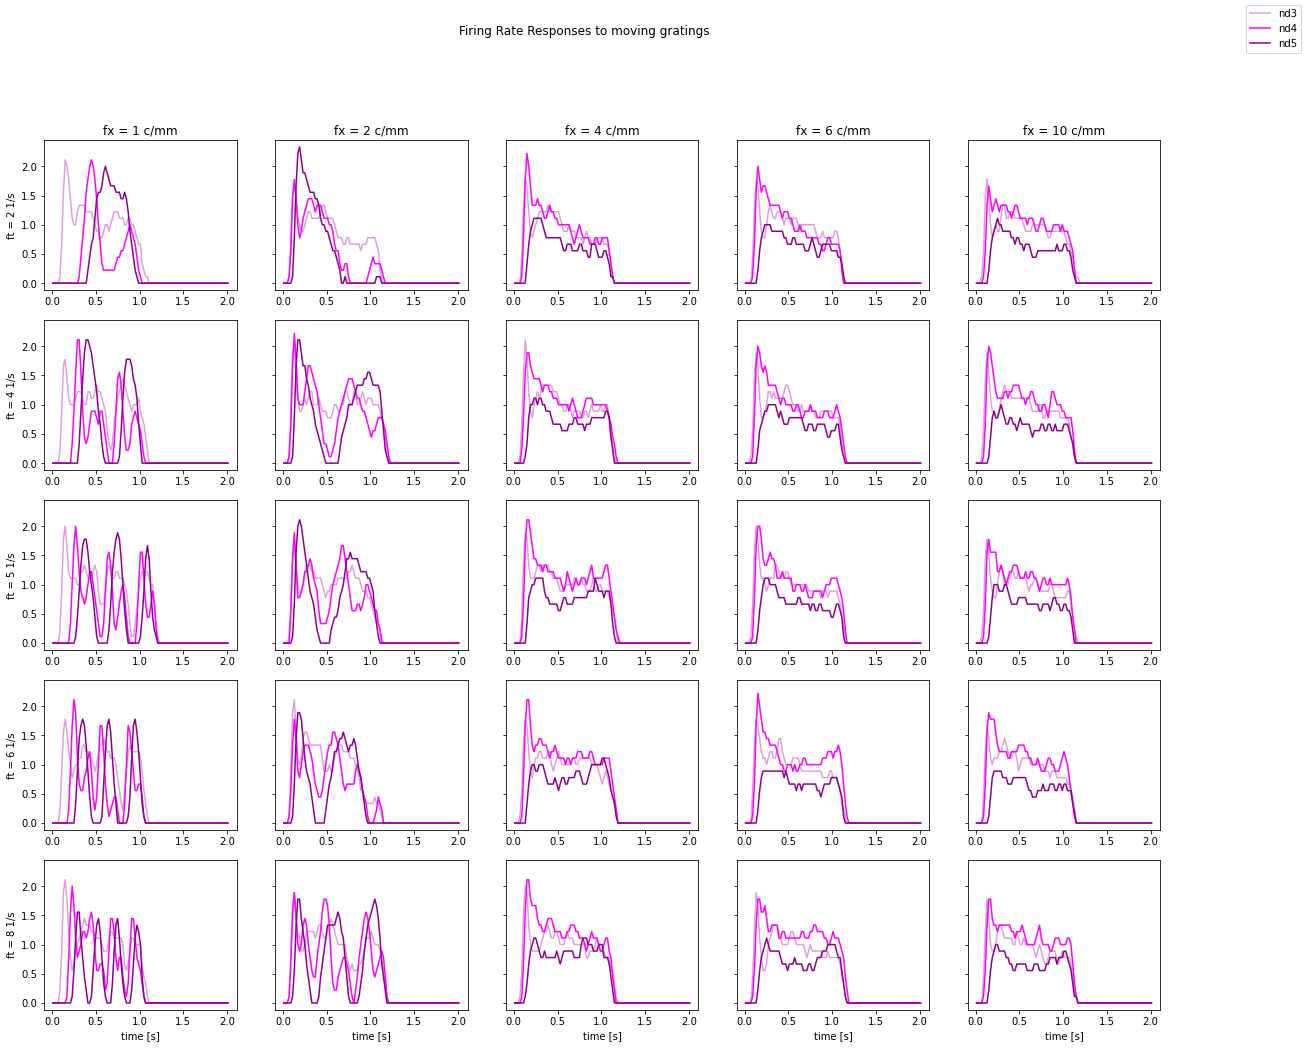

In [246]:
# resp_type = 'rasters_sorted_stim'
colors_moving = ['plum','magenta','darkmagenta']

resp_type = 'counts_sorted_stim_alinged'
#resp_type = 'counts_sorted_stim'
grat = grating_types[1]

fig,ax = plt.subplots(5,5, sharey = True, figsize = (20,16))
fxs = [1,2,4,6,10]
fts = [2,4,5,6,8]

heatdf_moving = pd.DataFrame(columns = ['fx', 'ft', 'max','intensity'])

for nbs in range(nb_stimuli):

    for ix,i in enumerate(intensities):
        row ={}

        y = int(np.floor(nbs/5))
        row['fx'] = float(fxs[y])
        
        x = int(nbs%5)
        row['ft'] = float(fts[x])
        row['v'] = float(fts[x]/fxs[y])

        row['intensity'] = i

        resp = data[key][i][grat][resp_type][nbs]
        stim = data['stimuli'][i][grat]['stimuli_sorted_stim']
        
        mean_stim = np.mean(resp[:idx])
        mean_base = np.mean(resp[idx:])
        mean_ratio = mean_stim/mean_base

        data[key][i][grat]['means_stim'] = mean_stim
        data[key][i][grat]['means_base'] = mean_base
        data[key][i][grat]['means_ratio'] = mean_ratio

        row['max'] = float(resp.max())
        row['mean_stim'] = float(mean_stim)
        row['mean_base'] = float(mean_base)
        row['mean_ratio'] = float(mean_ratio)

        heatdf_moving = heatdf_moving.append(row, ignore_index=True)
        #ax[x,y].eventplot(resp)
        if nbs == 0:
            ax[x,y].plot((time_ot+0.5*dt_sec),resp, color = colors_moving[ix], label = f'{i}')
        else:
            ax[x,y].plot((time_ot+0.5*dt_sec),resp, color = colors_moving[ix])
        #ax[x,y].plot(stim, color = colors_moving[ix])

ax[0,0].set_title('fx = 1 c/mm')
ax[0,1].set_title('fx = 2 c/mm')
ax[0,2].set_title('fx = 4 c/mm')
ax[0,3].set_title('fx = 6 c/mm')
ax[0,4].set_title('fx = 10 c/mm')

ax[0,0].set_ylabel('ft = 2 1/s')
ax[1,0].set_ylabel('ft = 4 1/s')
ax[2,0].set_ylabel('ft = 5 1/s')
ax[3,0].set_ylabel('ft = 6 1/s')
ax[4,0].set_ylabel('ft = 8 1/s')

ax[4,0].set_xlabel('time [s]')
ax[4,1].set_xlabel('time [s]')
ax[4,2].set_xlabel('time [s]')
ax[4,3].set_xlabel('time [s]')
ax[4,4].set_xlabel('time [s]')

fig.legend()
fig.suptitle(f'Firing Rate Responses to {grat} gratings')

# PLOT - Tuning  curves

In [247]:
from lmfit.models import SkewedGaussianModel
model = SkewedGaussianModel()
# set initial parameter values



## flicker
### compare frequencies

Text(0.5, 0.98, 'mean_stim firing rate tuning curves to flickering grating, sorted by stimulus density')

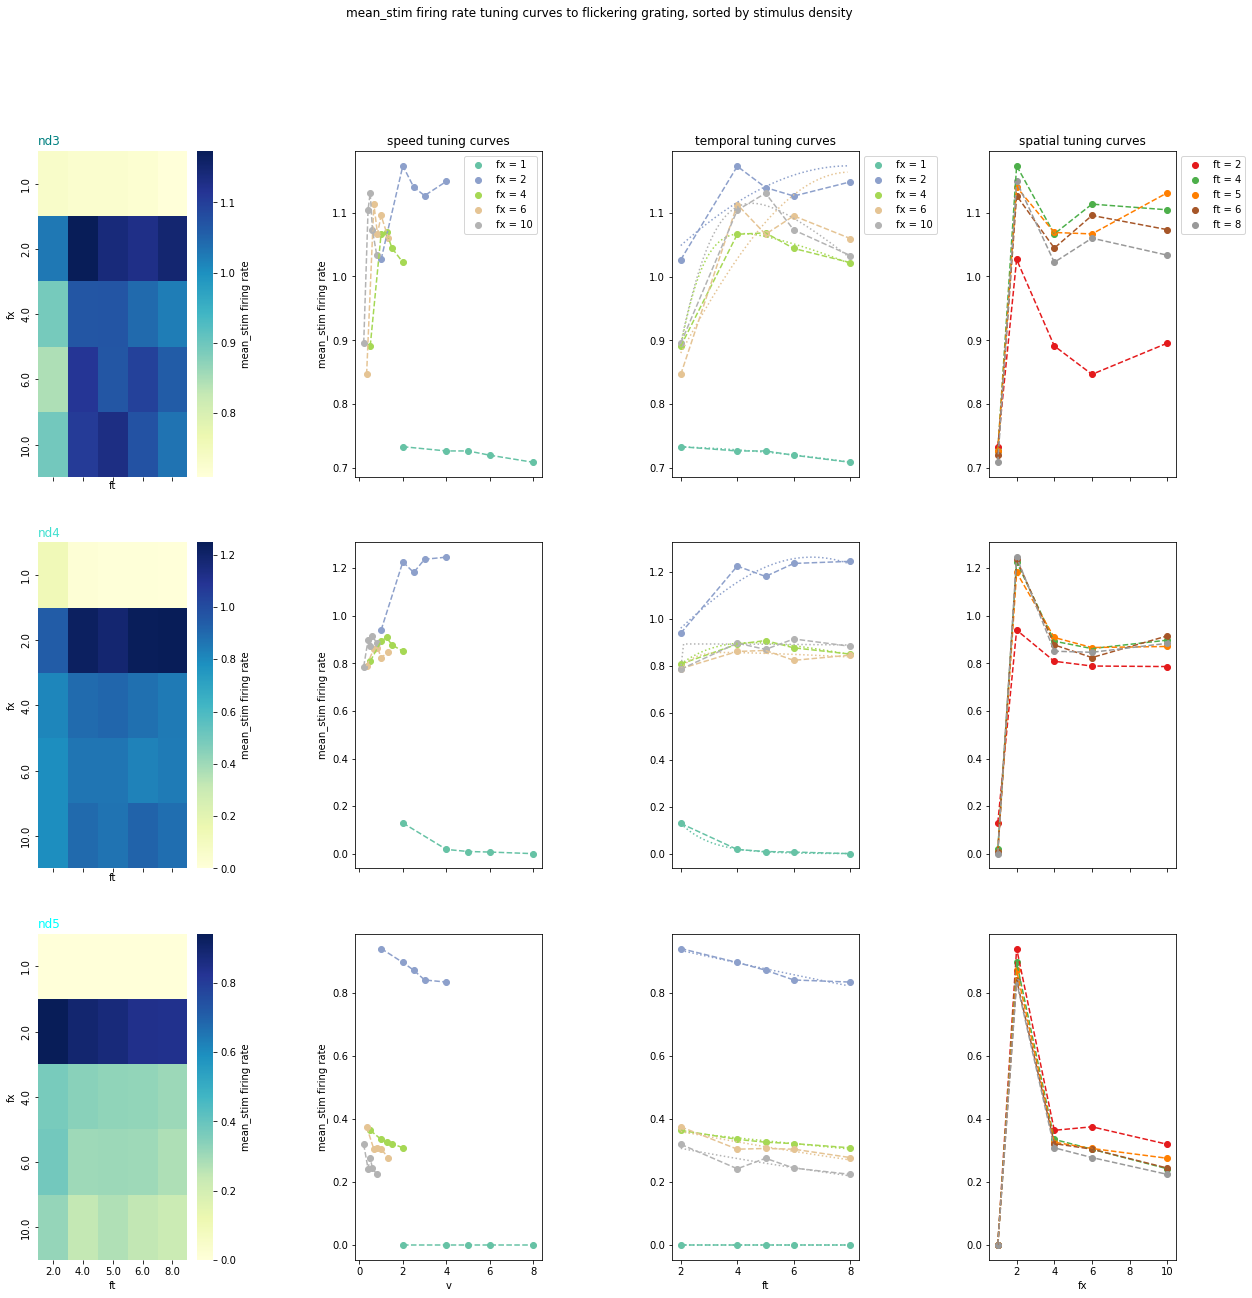

In [248]:
grat = grating_types[0]
target = 'mean_stim'

grouped = heatdf_flicker.groupby('intensity')

cmap_temporal = plt.get_cmap('Set1', len(fts))

cmap_spatial = plt.get_cmap('Set2', len(fxs))

fig, ax = plt.subplots(3,4, sharex = 'col', figsize = (20,20))

fig.subplots_adjust(top=0.88,
bottom=0.11,
left=0.11,
right=0.9,
hspace=0.2,
wspace=0.7)

for ix,i in enumerate(intensities):

    heatdf_i = grouped.get_group(i)
    heatplot = heatdf_i.pivot_table(index='fx', columns='ft', values=target)

    sns.heatmap(heatplot, ax = ax[ix,0],cmap = 'YlGnBu', cbar_kws={'label' :f'{target} firing rate'})
    ax[ix,0].set_title(f'{i}', loc = 'left', color = colors_flicker[ix])


    for fxi,fx in enumerate(fxs):
        max_ft = heatdf_i[heatdf_i['fx' ] == fx][target].values
        ft_ft = heatdf_i[heatdf_i['fx' ] == fx]['ft'].values
        v_ft = heatdf_i[heatdf_i['fx' ] == fx]['v'].values

        # fit skewed gaussian
        ftwide = np.arange(ft_ft.min(),ft_ft.max(),0.1)
        params = model.make_params(amplitude= max_ft.max(), center = ft_ft[max_ft.argmax()], sigma=1, gamma=0)
        result = model.fit(max_ft, params, x=ft_ft)
        predicted = model.eval(result.params, x=ftwide)

        ax[ix,2].scatter(ft_ft, max_ft, label = f'fx = {fx}', color = cmap_spatial(fxi))
        ax[ix,2].plot(ftwide, predicted, linestyle = ':', color = cmap_spatial(fxi)) 

        ax[ix,2].plot(ft_ft, max_ft, linestyle = '--', color = cmap_spatial(fxi))
        ax[-1,2].set_xlabel('ft')

        if ix == 0:
            ax[ix,2].legend(bbox_to_anchor=(1., 1.))
        ax[0,2].set_title('temporal tuning curves')
        #ax[ix,2].set_ylabel(f'{target} firing rate')

        # fit skewed gaussian
        vwide = np.arange(v_ft.min(),v_ft.max(),0.1)
        params = model.make_params(amplitude= max_ft.max(), center = v_ft[max_ft.argmax()], sigma=1, gamma=0)
        result = model.fit(max_ft, params, x=v_ft)
        predicted = model.eval(result.params, x=vwide)

        ax[ix,1].scatter(v_ft, max_ft, label = f'fx = {fx}', color = cmap_spatial(fxi))
        #ax[ix,1].plot(vwide, predicted, linestyle = ':', color = cmap_spatial(fxi)) 

        ax[ix,1].plot(v_ft, max_ft, linestyle = '--', color = cmap_spatial(fxi))
        ax[-1,1].set_xlabel('v')

        if ix == 0:
            ax[ix,1].legend(bbox_to_anchor=(1., 1.))
        ax[0,1].set_title('speed tuning curves')
        ax[ix,1].set_ylabel(f'{target} firing rate')


    for fti,ft in enumerate(fts):
        max_fx = heatdf_i[heatdf_i['ft' ] == ft][target]
        fx_fx = heatdf_i[heatdf_i['ft' ] == ft]['fx']
        ax[ix,3].scatter(fx_fx, max_fx, label = f'ft = {ft}', color = cmap_temporal(fti))
        ax[ix,3].plot(fx_fx, max_fx, linestyle = '--', color = cmap_temporal(fti))
        
        if ix ==0:
            ax[ix,3].legend(bbox_to_anchor=(1., 1.))
        ax[0,3].set_title('spatial tuning curves')
        ax[-1,3].set_xlabel('fx')
        #ax[ix,3].set_ylabel(f'{target} firing rate')

fig.suptitle(f'{target} firing rate tuning curves to flickering grating, sorted by stimulus density')

### compare intensities

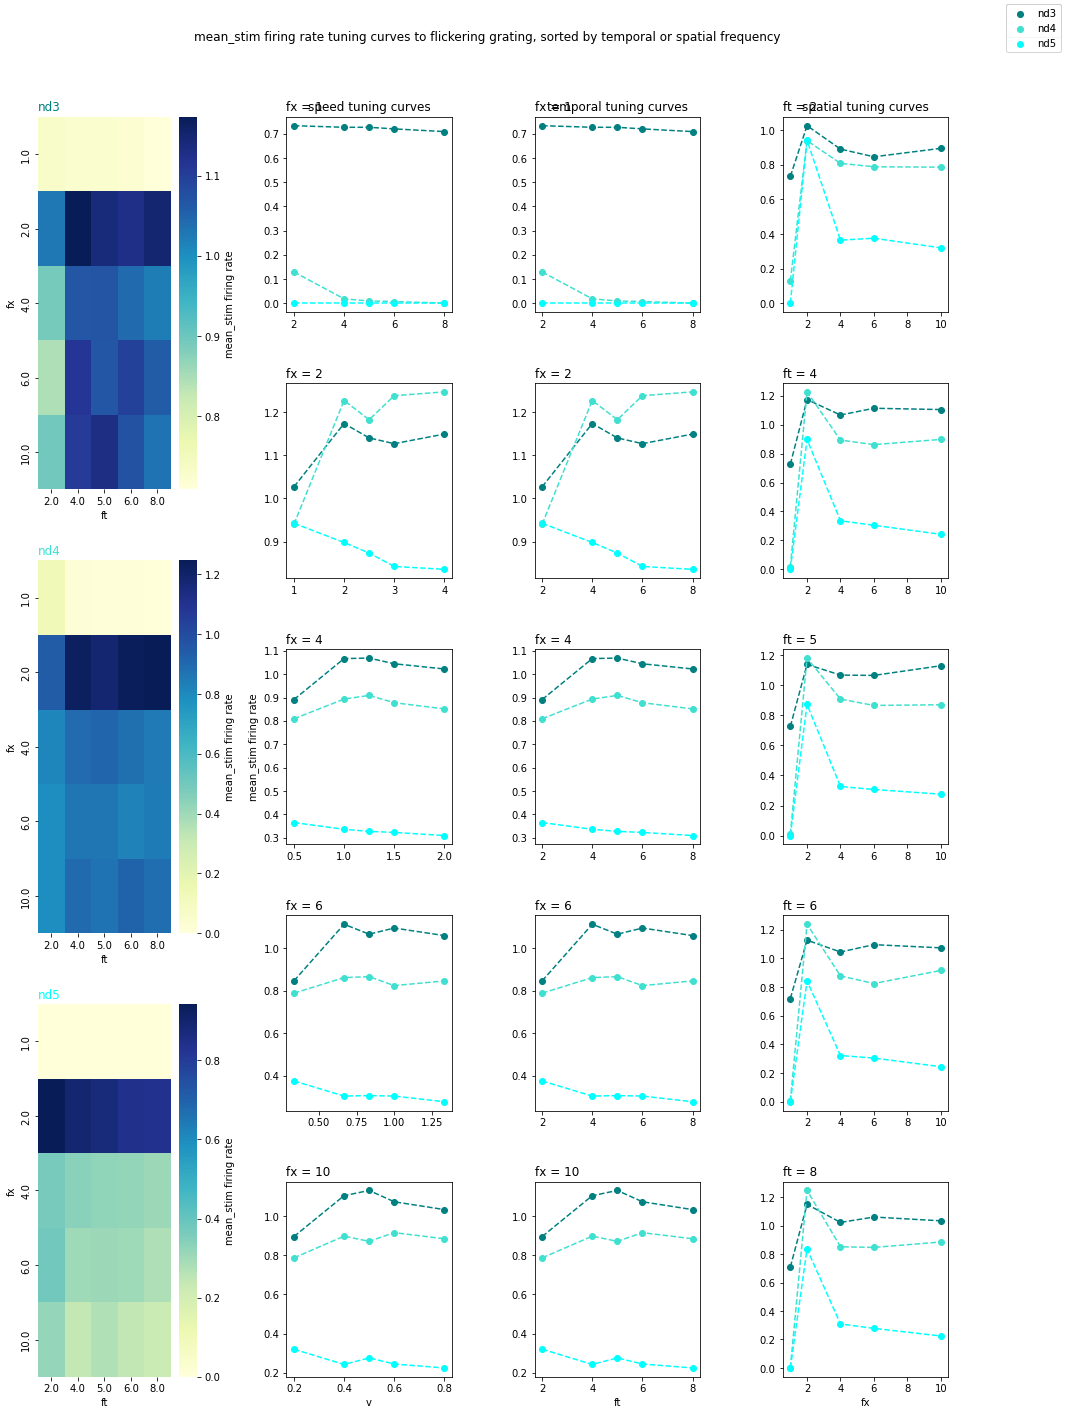

In [249]:

# fig, ax = plt.subplots(6,3, figsize = (20,16))
# fig.tight_layout()

fig = plt.figure(figsize = (16,20))
gs = fig.add_gridspec(15,4)
fig.subplots_adjust(top=0.92,
                    bottom=0.045,
                    left=0.11,
                    right=0.9,
                    hspace=4.0,
                    wspace=0.5)

axs1 = []
axs0 = []
axs2 = []

for ix,i in enumerate(intensities):
    heatdf_i = grouped.get_group(i)
    heatplot = heatdf_i.pivot_table(index='fx', columns='ft', values=target)

    ax = fig.add_subplot(gs[ix*5:ix*5+5,0])
    sns.heatmap(heatplot, ax = ax,cmap = 'YlGnBu', cbar_kws={'label' :f'{target} firing rate'})

    ax.set_title(f'{i}', loc = 'left', color = colors_flicker[ix])

    for fxx,fx in enumerate(fxs):
        max_ft = heatdf_i[heatdf_i['fx' ] == fx][target]
        ft_ft = heatdf_i[heatdf_i['fx' ] == fx]['ft']
        v_ft = heatdf_i[heatdf_i['fx' ] == fx]['v']

        if ix == 0 :
            axs1.append(fig.add_subplot(gs[fxx*3:fxx*3+3,2]))
            axs0.append(fig.add_subplot(gs[fxx*3:fxx*3+3,1]))


        if fxx == 0:
            axs1[fxx].scatter(ft_ft, max_ft, label = f'{i}', color = colors_flicker[ix])


        else:
            axs1[fxx].scatter(ft_ft, max_ft, color = colors_flicker[ix])

        axs1[fxx].plot(ft_ft, max_ft, linestyle = '--', color = colors_flicker[ix])
        axs1[fxx].set_title(f'fx = {fx}', loc = 'left')

        axs1[0].set_title('temporal tuning curves')
        #axs1[2].set_ylabel(f'{target} firing rate')

        axs0[fxx].scatter(v_ft, max_ft, color = colors_flicker[ix])
        axs0[fxx].plot(v_ft, max_ft, linestyle = '--', color = colors_flicker[ix])
        axs0[fxx].set_title(f'fx = {fx}', loc = 'left')

        axs0[0].set_title('speed tuning curves')

    for ftx,ft in enumerate(fts):

        if ix == 0:
            axs2.append(fig.add_subplot(gs[ftx*3 :ftx*3+3,3]))

        max_fx = heatdf_i[heatdf_i['ft' ] == ft][target]
        fx_fx = heatdf_i[heatdf_i['ft' ] == ft]['fx']

        axs2[ftx].scatter(fx_fx, max_fx, color = colors_flicker[ix])
        axs2[ftx].plot(fx_fx, max_fx, linestyle = '--', color = colors_flicker[ix])
        axs2[0].set_title('spatial tuning curves')
        #axs2[ftx].set_ylabel(f'{target} firing rate')
        axs2[ftx].set_title(f'ft = {ft}', loc = 'left')

    axs1[-1].set_xlabel('ft')
    axs0[-1].set_xlabel('v')
    axs0[2].set_ylabel(f'{target} firing rate')
    axs2[-1].set_xlabel('fx')

    fig.legend()

    fig.suptitle(f'{target} firing rate tuning curves to flickering grating, sorted by temporal or spatial frequency')


## moving
### compare frequencies

Text(0.5, 0.98, 'mean_stim firing rate tuning curves to moving grating, sorted by light density')

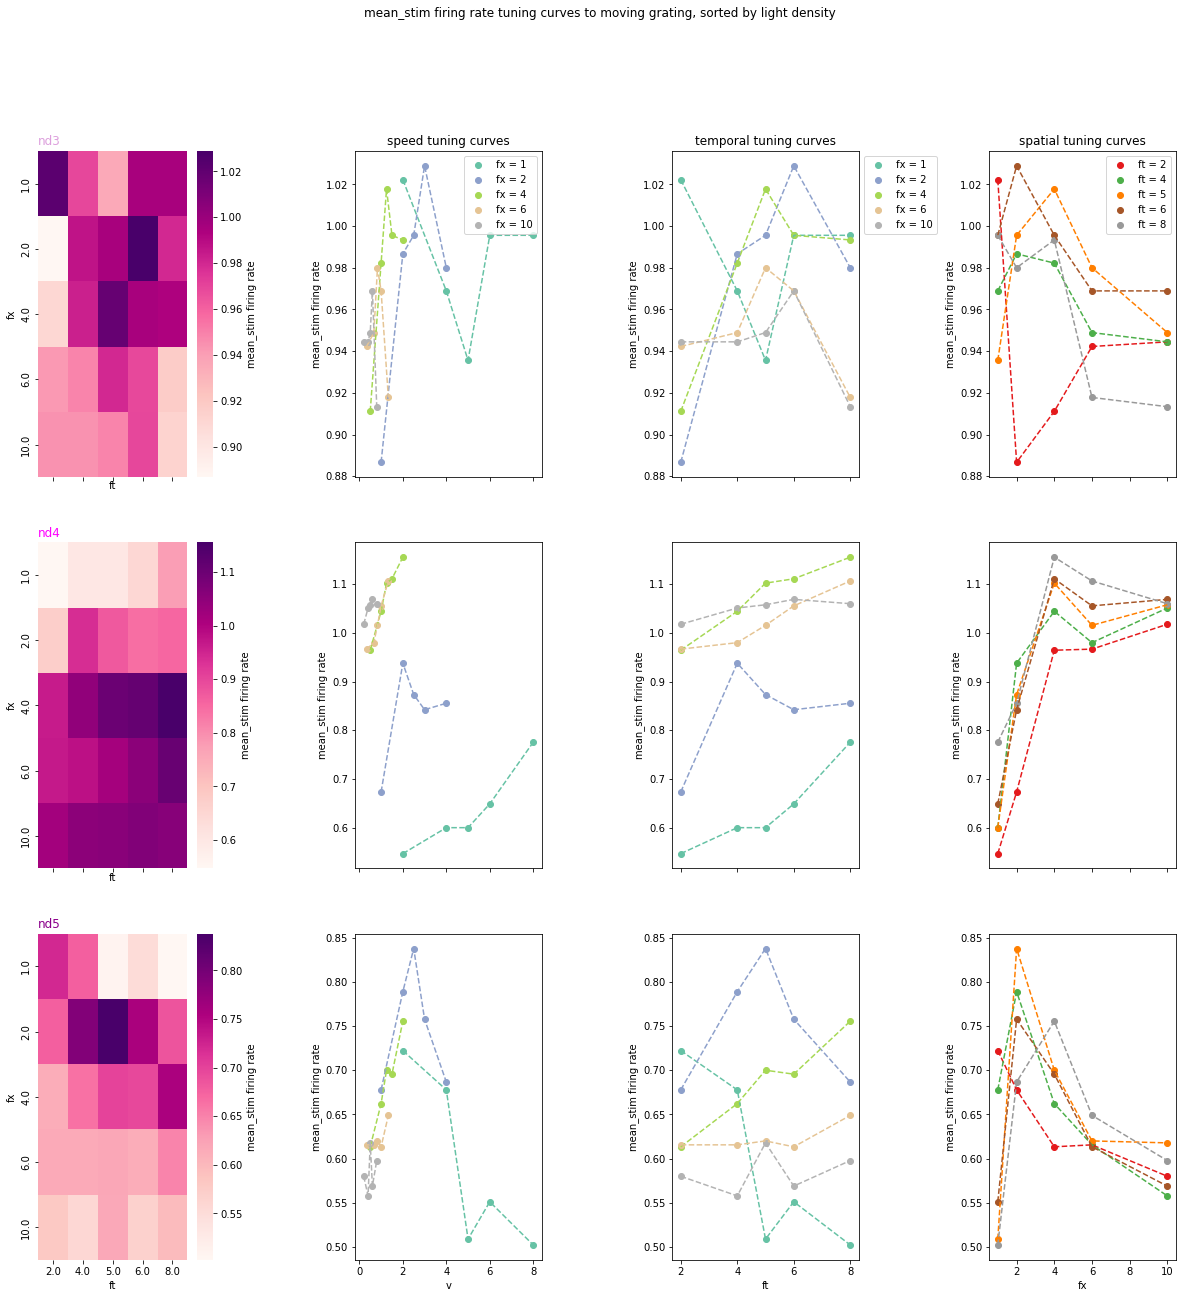

In [250]:
grat = grating_types[1]

grouped = heatdf_moving.groupby('intensity')

fig, ax = plt.subplots(3,4, sharex = 'col', figsize = (20,20))


fig.subplots_adjust(top=0.88,
bottom=0.11,
left=0.11,
right=0.9,
hspace=0.2,
wspace=0.7)


for ix,i in enumerate(intensities):

    heatdf_i = grouped.get_group(i)
    heatplot = heatdf_i.pivot_table(index='fx', columns='ft', values=target)

    sns.heatmap(heatplot, ax = ax[ix,0],cmap = 'RdPu', cbar_kws={'label' :f'{target} firing rate'})
    ax[ix,0].set_title(f'{i}', loc = 'left', color = colors_moving[ix])

    for fxi,fx in enumerate(fxs):
        max_ft = heatdf_i[heatdf_i['fx' ] == fx][target]
        ft_ft = heatdf_i[heatdf_i['fx' ] == fx]['ft']
        v_ft = heatdf_i[heatdf_i['fx' ] == fx]['v']

        ax[ix,2].scatter(ft_ft, max_ft, label = f'fx = {fx}', color = cmap_spatial(fxi))
        ax[ix,2].plot(ft_ft, max_ft, linestyle = '--', color = cmap_spatial(fxi))
        ax[-1,2].set_xlabel('ft')

        if ix ==0 :
            ax[ix,2].legend(bbox_to_anchor=(1., 1.))
        ax[0,2].set_title('temporal tuning curves')
        ax[ix,2].set_ylabel(f'{target} firing rate')


        
        ax[ix,1].scatter(v_ft, max_ft, label = f'fx = {fx}', color = cmap_spatial(fxi))
        ax[ix,1].plot(v_ft, max_ft, linestyle = '--', color = cmap_spatial(fxi))
        ax[-1,1].set_xlabel('v')

        if ix == 0 :
            ax[ix,1].legend(bbox_to_anchor=(1., 1.))
        ax[0,1].set_title('speed tuning curves')
        ax[ix,1].set_ylabel(f'{target} firing rate')


    for fti,ft in enumerate(fts):
        max_fx = heatdf_i[heatdf_i['ft' ] == ft][target]
        fx_fx = heatdf_i[heatdf_i['ft' ] == ft]['fx']
        ax[ix,3].scatter(fx_fx, max_fx, label = f'ft = {ft}', color = cmap_temporal(fti))
        ax[ix,3].plot(fx_fx, max_fx, linestyle = '--', color = cmap_temporal(fti))
        if ix == 0:
            ax[ix,3].legend(bbox_to_anchor=(1., 1.))
        ax[0,3].set_title('spatial tuning curves')
        ax[-1,3].set_xlabel('fx')
        ax[ix,3].set_ylabel(f'{target} firing rate')


fig.suptitle(f'{target} firing rate tuning curves to moving grating, sorted by light density')


### compare intensitites

0
0
0
0
0


Text(0.5, 0.98, 'mean_stim firing rate tuning curves to moving grating, sorted by temporal or spatial frequency')

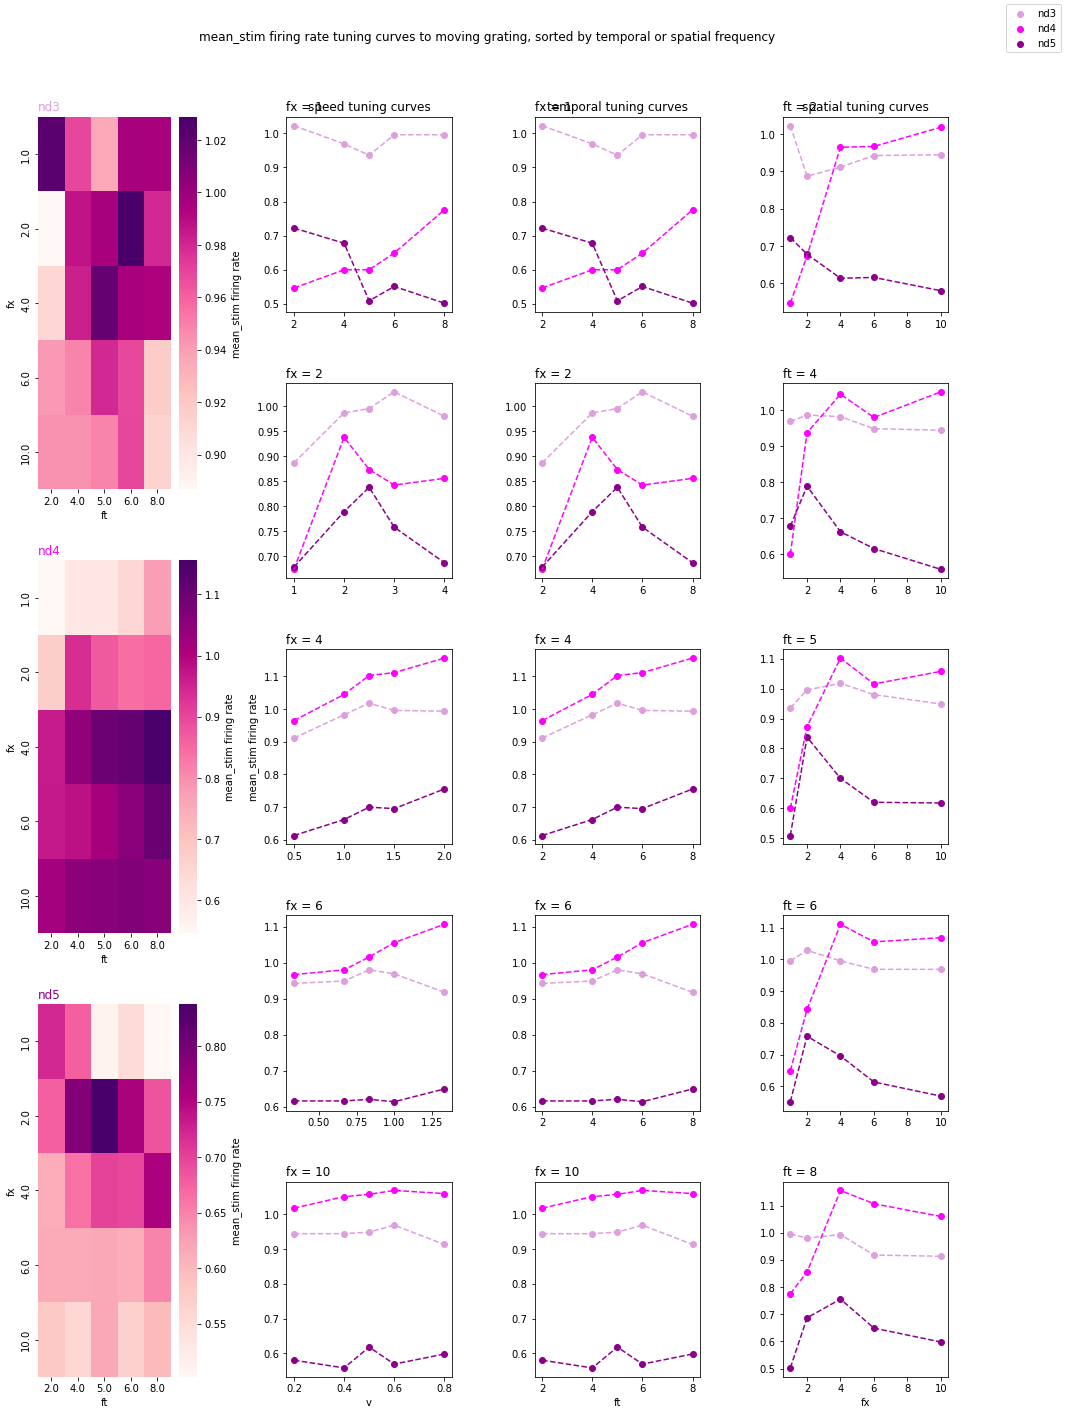

In [251]:

# fig, ax = plt.subplots(6,3, figsize = (20,16))
# fig.tight_layout()

fig = plt.figure(figsize = (16,20))
gs = fig.add_gridspec(15,4)
fig.subplots_adjust(top=0.92,
                    bottom=0.045,
                    left=0.11,
                    right=0.9,
                    hspace=4.0,
                    wspace=0.5)

axs1 = []
axs0 = []
axs2 = []

for ix,i in enumerate(intensities):
    heatdf_i = grouped.get_group(i)
    heatplot = heatdf_i.pivot_table(index='fx', columns='ft', values=target)

    ax = fig.add_subplot(gs[ix*5:ix*5+5,0])
    sns.heatmap(heatplot, ax = ax,cmap = 'RdPu', cbar_kws={'label' :f'{target} firing rate'})

    ax.set_title(f'{i}', loc = 'left', color = colors_moving[ix])

    for fxx,fx in enumerate(fxs):
        max_ft = heatdf_i[heatdf_i['fx' ] == fx][target]
        ft_ft = heatdf_i[heatdf_i['fx' ] == fx]['ft']
        v_ft = heatdf_i[heatdf_i['fx' ] == fx]['v']

        if ix == 0 :
            print(ix)
            axs1.append(fig.add_subplot(gs[fxx*3:fxx*3+3,2]))
            axs0.append(fig.add_subplot(gs[fxx*3:fxx*3+3,1]))


        if fxx == 0:
            axs1[fxx].scatter(ft_ft, max_ft, label = f'{i}', color = colors_moving[ix])


        else:
            axs1[fxx].scatter(ft_ft, max_ft, color = colors_moving[ix])

        axs1[fxx].plot(ft_ft, max_ft, linestyle = '--', color = colors_moving[ix])
        axs1[fxx].set_title(f'fx = {fx}', loc = 'left')

        axs1[0].set_title('temporal tuning curves')
        #axs1[2].set_ylabel(f'{target} firing rate')

        axs0[fxx].scatter(v_ft, max_ft, color = colors_moving[ix])
        axs0[fxx].plot(v_ft, max_ft, linestyle = '--', color = colors_moving[ix])
        axs0[fxx].set_title(f'fx = {fx}', loc = 'left')

        axs0[0].set_title('speed tuning curves')

    for ftx,ft in enumerate(fts):

        if ix == 0:
            axs2.append(fig.add_subplot(gs[ftx*3 :ftx*3+3,3]))

        max_fx = heatdf_i[heatdf_i['ft' ] == ft][target]
        fx_fx = heatdf_i[heatdf_i['ft' ] == ft]['fx']

        axs2[ftx].scatter(fx_fx, max_fx, color = colors_moving[ix])
        axs2[ftx].plot(fx_fx, max_fx, linestyle = '--', color = colors_moving[ix])
        axs2[0].set_title('spatial tuning curves')
        #axs2[ftx].set_ylabel(f'{target} firing rate')
        axs2[ftx].set_title(f'ft = {ft}', loc = 'left')


    axs1[-1].set_xlabel('ft')
    axs0[-1].set_xlabel('v')
    axs0[2].set_ylabel(f'{target} firing rate')
    axs2[-1].set_xlabel('fx')



fig.legend()
fig.suptitle(f'{target} firing rate tuning curves to moving grating, sorted by temporal or spatial frequency')


# calculate measures
## responsiveness measure

In [252]:
data[key][i].keys(), i

(dict_keys(['flickering', 'moving']), 'nd5')

In [253]:
grat = 'moving'
i = 'nd3'

In [254]:
from numpy.fft import fft, rfft
from scipy.signal import spectrogram

In [255]:
len(time_ot), len(x),dt,N,T,

TypeError: object of type 'int' has no len()

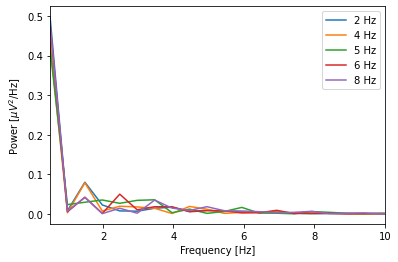

In [258]:

for fti,ft in enumerate(fts):
    x = data[key][i][grat]['counts_sorted_stim_alinged'][fti]  # Load the EEG data
    t = time_ot                                              # ... and the t variable

    dt = t[1] - t[0]                      # Define the sampling interval
    N = x.shape[0]                        # Define the total number of data points
    T = N * dt                            # Define the total duration of the data

    xf = fft(x - x.mean())                    # Compute Fourier transform of x
    Sxx = 2 * dt ** 2 / T * (xf * xf.conj())  # Compute spectrum
    Sxx = Sxx[:int(len(x) / 2)]               # Ignore negative frequencies

    df = 1 / T.max()                      # Determine frequency resolution
    fNQ = 1 / dt / 2                      # Determine Nyquist frequency
    faxis = np.arange(0,fNQ,df)[:-1]            # Construct frequency axis

    plt.plot(faxis,Sxx.real, label = f'{ft} Hz')                 # Plot spectrum vs frequency

plt.xlabel('Frequency [Hz]')              # Label the axes
plt.ylabel('Power [$\mu V^2$/Hz]')
plt.xlim(df,10)
plt.legend()

In [151]:
%matplotlib inline

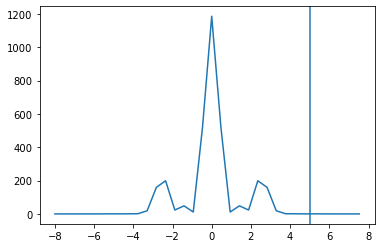

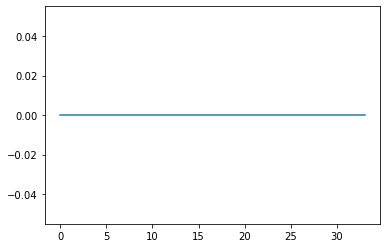

In [139]:
plt.plot(ostim)

In [ ]:
# look at speeds distribution for fx and ft 
plt.figure()
heatplot_speeds = heatdf_i.pivot_table(index='fx', columns='ft', values='v')
sns.heatmap(heatplot,cmap = 'viridis', cbar_kws={'label' :'v'})

In [ ]:
# changes for next experiments
    # more frequencies / adjust frequencies to same speeds for all fxs
    # contrast -> done
    # random order of stimuli